# Solving problems by Searching

This notebook serves as supporting material for topics covered in **Chapter 3 - Solving Problems by Searching** from the book *Artificial Intelligence: A Modern Approach.* This notebook uses implementations from [search.py](https://github.com/aimacode/aima-python/blob/master/search.py) module. Let's start by importing everything from search module.

In [1]:
from search import *
from notebook import psource, heatmap, gaussian_kernel, show_map, final_path_colors, display_visual, plot_NQueens

# Needed to hide warnings in the matplotlib sections
import warnings
warnings.filterwarnings("ignore")

## CONTENTS

* Overview
* Problem
* Node
* Simple Problem Solving Agent
* Search Algorithms Visualization
* Breadth-First Tree Search
* Breadth-First Search
* Depth-First Tree Search
* Depth-First Search
* Uniform Cost Search

## OVERVIEW

Here, we learn about a specific kind of problem solving - building goal-based agents that can plan ahead to solve problems. In particular, we examine navigation problem/route finding problem. We must begin by precisely defining **problems** and their **solutions**. We will look at several general-purpose search algorithms.

Search algorithms can be classified into two types:

* **Uninformed search algorithms**: Search algorithms which explore the search space without having any information about the problem other than its definition.
    * Examples:
        1. Breadth First Search
        2. Depth First Search
        3. Depth Limited Search
        4. Iterative Deepening Search
        5. Uniform Cost Search

*Don't miss the visualisations of these algorithms solving the route-finding problem defined on Romania map at the end of this notebook.*

For visualisations, we use networkx and matplotlib to show the map in the notebook and we use ipywidgets to interact with the map to see how the searching algorithm works. These are imported as required in `notebook.py`.

In [2]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import lines

from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
import time

## PROBLEM

Let's see how we define a Problem. Run the next cell to see how abstract class `Problem` is defined in the search module.

In [3]:
psource(Problem)

The `Problem` class has six methods.

* `__init__(self, initial, goal)` : This is what is called a `constructor`. It is the first method called when you create an instance of the class as `Problem(initial, goal)`. The variable `initial` specifies the initial state $s_0$ of the search problem. It represents the beginning state. From here, our agent begins its task of exploration to find the goal state(s) which is given in the `goal` parameter.


* `actions(self, state)` : This method returns all the possible actions agent can execute in the given state `state`.


* `result(self, state, action)` : This returns the resulting state if action `action` is taken in the state `state`. This `Problem` class only deals with deterministic outcomes. So we know for sure what every action in a state would result to.


* `goal_test(self, state)` : Return a boolean for a given state - `True` if it is a goal state, else `False`.


* `path_cost(self, c, state1, action, state2)` : Return the cost of the path that arrives at `state2` as a result of taking `action` from `state1`, assuming total cost of `c` to get up to `state1`.


* `value(self, state)` : This acts as a bit of extra information in problems where we try to optimise a value when we cannot do a goal test.

## NODE

Let's see how we define a Node. Run the next cell to see how abstract class `Node` is defined in the search module.

In [4]:
psource(Node)

The `Node` class has nine methods. The first is the `__init__` method.

* `__init__(self, state, parent, action, path_cost)` : This method creates a node. `parent` represents the node that this is a successor of and `action` is the action required to get from the parent node to this node. `path_cost` is the cost to reach current node from parent node.

The next 4 methods are specific `Node`-related functions.

* `expand(self, problem)` : This method lists all the neighbouring(reachable in one step) nodes of current node. 

* `child_node(self, problem, action)` : Given an `action`, this method returns the immediate neighbour that can be reached with that `action`.

* `solution(self)` : This returns the sequence of actions required to reach this node from the root node. 

* `path(self)` : This returns a list of all the nodes that lies in the path from the root to this node.

The remaining 4 methods override standards Python functionality for representing an object as a string, the less-than ($<$) operator, the equal-to ($=$) operator, and the `hash` function.

* `__repr__(self)` : This returns the state of this node.

* `__lt__(self, node)` : Given a `node`, this method returns `True` if the state of current node is less than the state of the `node`. Otherwise it returns `False`.

* `__eq__(self, other)` : This method returns `True` if the state of current node is equal to the other node. Else it returns `False`.

* `__hash__(self)` : This returns the hash of the state of current node.

We will use the abstract class `Problem` to define our real **problem** named `GraphProblem`. You can see how we define `GraphProblem` by running the next cell.

In [5]:
psource(GraphProblem)

Have a look at our romania_map, which is an Undirected Graph containing a dict of nodes as keys and neighbours as values.

In [6]:
romania_map = UndirectedGraph(dict(
    Arad=dict(Zerind=75, Sibiu=140, Timisoara=118),
    Bucharest=dict(Urziceni=85, Pitesti=101, Giurgiu=90, Fagaras=211),
    Craiova=dict(Drobeta=120, Rimnicu=146, Pitesti=138),
    Drobeta=dict(Mehadia=75),
    Eforie=dict(Hirsova=86),
    Fagaras=dict(Sibiu=99),
    Hirsova=dict(Urziceni=98),
    Iasi=dict(Vaslui=92, Neamt=87),
    Lugoj=dict(Timisoara=111, Mehadia=70),
    Oradea=dict(Zerind=71, Sibiu=151),
    Pitesti=dict(Rimnicu=97),
    Rimnicu=dict(Sibiu=80),
    Urziceni=dict(Vaslui=142)))

romania_map.locations = dict(
    Arad=(91, 492), Bucharest=(400, 327), Craiova=(253, 288),
    Drobeta=(165, 299), Eforie=(562, 293), Fagaras=(305, 449),
    Giurgiu=(375, 270), Hirsova=(534, 350), Iasi=(473, 506),
    Lugoj=(165, 379), Mehadia=(168, 339), Neamt=(406, 537),
    Oradea=(131, 571), Pitesti=(320, 368), Rimnicu=(233, 410),
    Sibiu=(207, 457), Timisoara=(94, 410), Urziceni=(456, 350),
    Vaslui=(509, 444), Zerind=(108, 531))

It is pretty straightforward to understand this `romania_map`. The first node **Arad** has three neighbours named **Zerind**, **Sibiu**, **Timisoara**. Each of these nodes are 75, 140, 118 units apart from **Arad** respectively. And the same goes with other nodes.

And `romania_map.locations` contains the positions of each of the nodes. We will use the straight line distance (which is different from the one provided in `romania_map`) between two cities in algorithms like A\*-search and Recursive Best First Search.

**Define a problem:**
Now it's time to define our problem. We will define it by passing `initial`, `goal`, `graph` to `GraphProblem`. So, our problem is to find the goal state starting from the given initial state on the provided graph. 

Say we want to start exploring from **Arad** and try to find **Bucharest** in our romania_map. So, this is how we do it.

In [7]:
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)

### Romania Map Visualisation

Let's have a visualisation of Romania map [Figure 3.2] from the book and see how different searching algorithms perform / how frontier expands in each search algorithm for a simple problem named `romania_problem`.

Have a look at `romania_locations`. It is a dictionary defined in search module. We will use these location values to draw the romania graph using **networkx**.

In [8]:
romania_locations = romania_map.locations
print(romania_locations)

{'Arad': (91, 492), 'Bucharest': (400, 327), 'Craiova': (253, 288), 'Drobeta': (165, 299), 'Eforie': (562, 293), 'Fagaras': (305, 449), 'Giurgiu': (375, 270), 'Hirsova': (534, 350), 'Iasi': (473, 506), 'Lugoj': (165, 379), 'Mehadia': (168, 339), 'Neamt': (406, 537), 'Oradea': (131, 571), 'Pitesti': (320, 368), 'Rimnicu': (233, 410), 'Sibiu': (207, 457), 'Timisoara': (94, 410), 'Urziceni': (456, 350), 'Vaslui': (509, 444), 'Zerind': (108, 531)}


Let's get started by initializing an empty graph. We will add nodes, place the nodes in their location as shown in the book, add edges to the graph.

In [9]:
# node colors, node positions and node label positions
node_colors = {node: 'white' for node in romania_map.locations.keys()}
node_positions = romania_map.locations
node_label_pos = { k:[v[0],v[1]-10]  for k,v in romania_map.locations.items() }
edge_weights = {(k, k2) : v2 for k, v in romania_map.graph_dict.items() for k2, v2 in v.items()}

romania_graph_data = {  'graph_dict' : romania_map.graph_dict,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                         'edge_weights': edge_weights
                     }

We have completed building our graph based on romania_map and its locations. It's time to display it here in the notebook. This function `show_map(node_colors)` helps us do that. We will be calling this function later on to display the map at each and every interval step while searching, using variety of algorithms from the book.

We can simply call the function with node_colors dictionary object to display it.

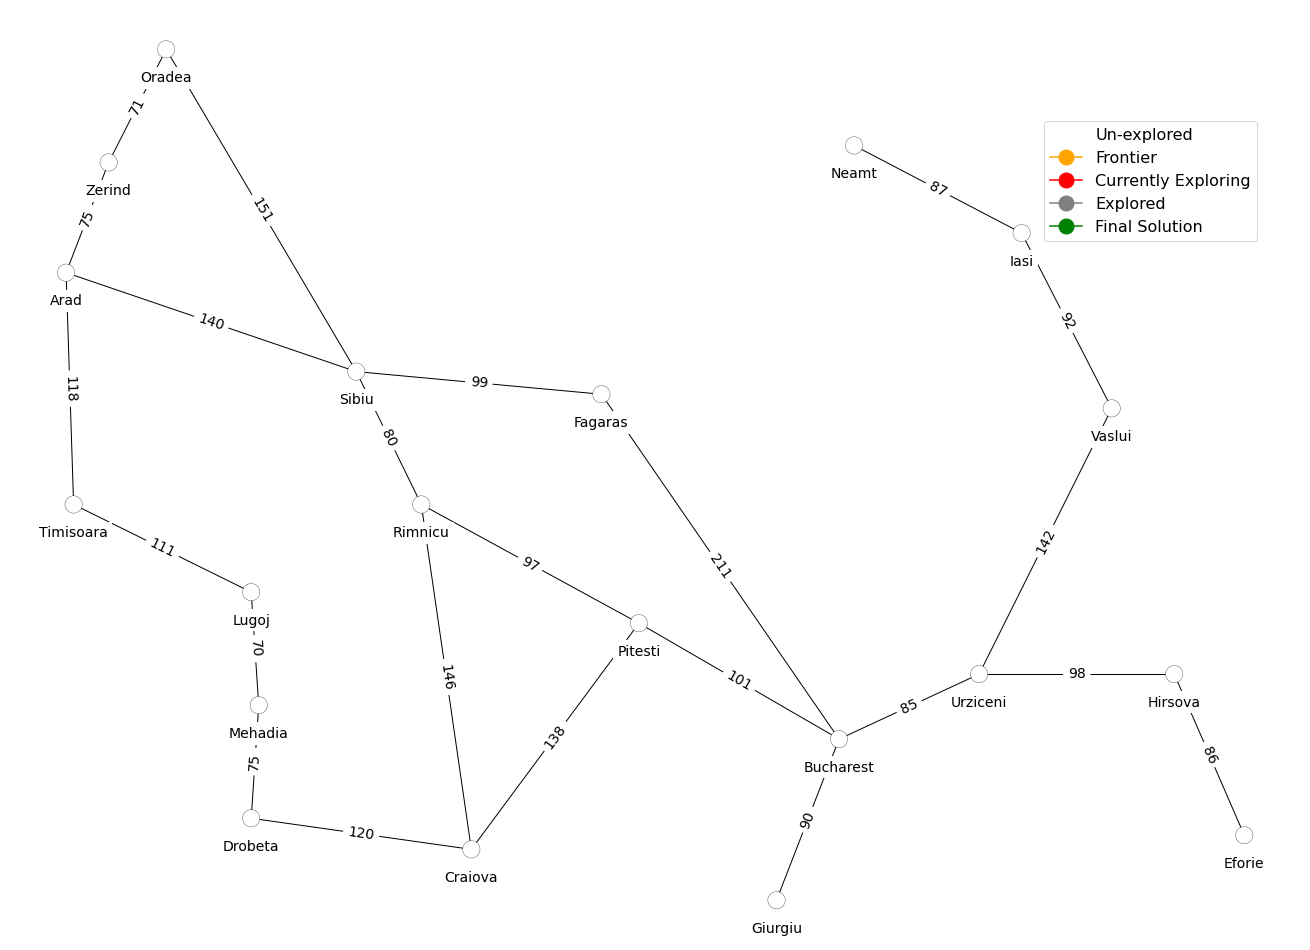

In [10]:
show_map(romania_graph_data)

Voila! You see, the romania map as shown in the Figure[3.2] in the book. Now, see how different searching algorithms perform with our problem statements.

## SIMPLE PROBLEM SOLVING AGENT PROGRAM

Let us now define a Simple Problem Solving Agent Program. Run the next cell to see how the abstract class `SimpleProblemSolvingAgentProgram` is defined in the search module.

In [11]:
psource(SimpleProblemSolvingAgentProgram)

The SimpleProblemSolvingAgentProgram class has six methods:  

* `__init__(self, intial_state=None)`: This is the `contructor` of the class and is the first method to be called when the class is instantiated. It takes in a keyword argument, `initial_state` which is initially `None`. The argument `initial_state` represents the state from which the agent starts.

* `__call__(self, percept)`: This method updates the `state` of the agent based on its `percept` using the `update_state` method. It then formulates a `goal` with the help of `formulate_goal` method and a `problem` using the `formulate_problem` method and returns a sequence of actions to solve it (using the `search` method).

* `update_state(self, percept)`: This method updates the `state` of the agent based on its `percept`.

* `formulate_goal(self, state)`: Given a `state` of the agent, this method formulates the `goal` for it.

* `formulate_problem(self, state, goal)`: It is used in problem formulation given a `state` and a `goal` for the `agent`.

* `search(self, problem)`: This method is used to search a sequence of `actions` to solve a `problem`.

Let us now define a Simple Problem Solving Agent Program. We will create a simple `vacuumAgent` class which will inherit from the abstract class `SimpleProblemSolvingAgentProgram` and overrides its methods. We will create a simple intelligent vacuum agent which can be in any one of the following states. It will move to any other state depending upon the current state as shown in the picture by arrows:

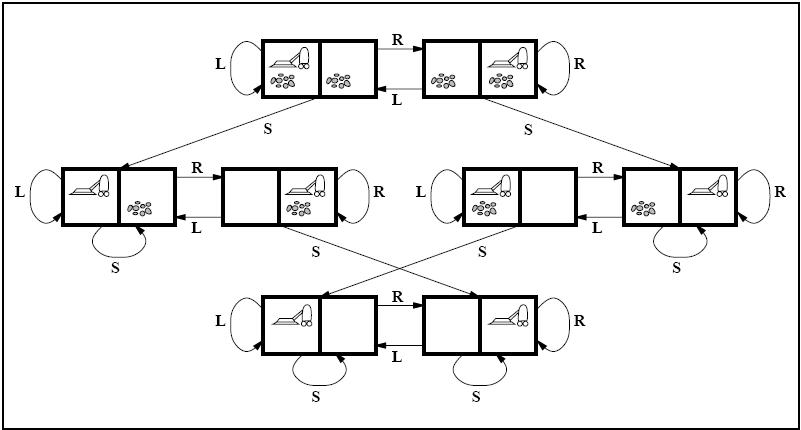

Fig : Simple problem solving agent

In [12]:
class vacuumAgent(SimpleProblemSolvingAgentProgram):
        def update_state(self, state, percept):
            return percept

        def formulate_goal(self, state):
            goal = [state7, state8]
            return goal  

        def formulate_problem(self, state, goal):
            problem = state
            return problem   
    
        def search(self, problem):
            seq = ["None"]
            if problem == state1:
                seq = ["Suck", "Right", "Suck"]
            elif problem == state2:
                seq = ["Suck", "Left", "Suck"]
            elif problem == state3:
                seq = ["Right", "Suck"]
            elif problem == state4:
                seq = ["Suck"]
            elif problem == state5:
                seq = ["Suck"]
            elif problem == state6:
                seq = ["Left", "Suck"]
            return seq

Now, we will define all the 8 states and create an object of the above class. Then, we will pass it different states and check the output:

In [13]:
state1 = [(0, 0), [(0, 0), "Dirty"], [(1, 0), ["Dirty"]]]
state2 = [(1, 0), [(0, 0), "Dirty"], [(1, 0), ["Dirty"]]]
state3 = [(0, 0), [(0, 0), "Clean"], [(1, 0), ["Dirty"]]]
state4 = [(1, 0), [(0, 0), "Clean"], [(1, 0), ["Dirty"]]]
state5 = [(0, 0), [(0, 0), "Dirty"], [(1, 0), ["Clean"]]]
state6 = [(1, 0), [(0, 0), "Dirty"], [(1, 0), ["Clean"]]]
state7 = [(0, 0), [(0, 0), "Clean"], [(1, 0), ["Clean"]]]
state8 = [(1, 0), [(0, 0), "Clean"], [(1, 0), ["Clean"]]]

a = vacuumAgent(state1)

print(a(state6)) 
print(a(state1))
print(a(state3))

Left
Suck
Right


**Task 1** **[5%]**

1) Print the output of the robot at every state, considering that is its current state and explain the output logic.

2) From each current state, describe where would it move next.

In [14]:
print(a(state1))
print(a(state2))
print(a(state3))
print(a(state4))
print(a(state5))
print(a(state6)) 
print(a(state7))
print(a(state8))

Suck
Suck
Left
Suck
Suck
Left
Suck
None


## SEARCHING ALGORITHMS VISUALIZATION

In this section, we have visualizations of the following searching algorithms:

1. Breadth First Tree Search
2. Depth First Tree Search
3. Breadth First Search
4. Depth First Graph Search
5. Uniform Cost Search
6. Depth Limited Search
7. Iterative Deepening Search

Useful reference to to know more about uninformed search: 

https://www.geeksforgeeks.org/breadth-first-search-or-bfs-for-a-graph/

https://medium.com/nothingaholic/depth-first-search-vs-breadth-first-search-in-python-81521caa8f44

https://algodaily.com/lessons/dfs-vs-bfs

https://towardsdatascience.com/search-algorithm-dijkstras-algorithm-uniform-cost-search-with-python-ccbee250ba9

https://ai-master.gitbooks.io/classic-search/content/what-is-depth-limited-search.html

https://www.educative.io/edpresso/what-is-iterative-deepening-search


We add the colors to the nodes to have a nice visualisation when displaying. So, these are the different colors we are using in these visuals:
* Un-explored nodes - <font color='black'>white</font>
* Frontier nodes - <font color='orange'>orange</font>
* Currently exploring node - <font color='red'>red</font>
* Already explored nodes - <font color='gray'>gray</font>

## 1. BREADTH-FIRST TREE SEARCH

We have a working implementation in search module. But as we want to interact with the graph while it is searching, we need to modify the implementation. Here's the modified breadth first tree search.




In [15]:
def tree_breadth_search_for_vis(problem):
    """Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Don't worry about repeated paths to a state. [Figure 3.7]"""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    #Adding first node to the queue
    frontier = deque([Node(problem.initial)])
    
    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    while frontier:
        #Popping first node of queue
        node = frontier.popleft()
        
        # modify the currently searching node to red
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            # modify goal node to green after reaching the goal
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        frontier.extend(node.expand(problem))
           
        for n in node.expand(problem):
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))

        # modify the color of explored nodes to gray
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
    return None

def breadth_first_tree_search(problem):
    "Search the shallowest nodes in the search tree first."
    iterations, all_node_colors, node = tree_breadth_search_for_vis(problem)
    return(iterations, all_node_colors, node)

Now, we use `ipywidgets` to display a slider, a button and our romania map. By sliding the slider we can have a look at all the intermediate steps of a particular search algorithm. By pressing the button **Visualize**, you can see all the steps without interacting with the slider. These two helper functions are the callback functions which are called when we interact with the slider and the button.

In [16]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
a, b, c = breadth_first_tree_search(romania_problem)
display_visual(romania_graph_data, user_input=False, 
               algorithm=breadth_first_tree_search, 
               problem=romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 2. DEPTH-FIRST TREE SEARCH
Now let's discuss another searching algorithm, Depth-First Tree Search.

In [17]:
def tree_depth_search_for_vis(problem):
    """Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    Don't worry about repeated paths to a state. [Figure 3.7]"""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    #Adding first node to the stack
    frontier = [Node(problem.initial)]
    
    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    while frontier:
        #Popping first node of stack
        node = frontier.pop()
        
        # modify the currently searching node to red
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            # modify goal node to green after reaching the goal
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        frontier.extend(node.expand(problem))
           
        for n in node.expand(problem):
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))

        # modify the color of explored nodes to gray
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
    return None

def depth_first_tree_search(problem):
    "Search the deepest nodes in the search tree first."
    iterations, all_node_colors, node = tree_depth_search_for_vis(problem)
    return(iterations, all_node_colors, node)

In [18]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input=False, 
               algorithm=depth_first_tree_search, 
               problem=romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 3. BREADTH-FIRST GRAPH SEARCH

Let's change all the `node_colors` to starting position and define a different problem statement.

In [19]:
def breadth_first_search_graph(problem):
    "[Figure 3.11]"
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    node = Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
      
    if problem.goal_test(node.state):
        node_colors[node.state] = "green"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    frontier = deque([node])
    
    # modify the color of frontier nodes to blue
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
        
    explored = set()
    while frontier:
        node = frontier.popleft()
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        explored.add(node.state)     
        
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                if problem.goal_test(child.state):
                    node_colors[child.state] = "green"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))
                    return(iterations, all_node_colors, child)
                frontier.append(child)

                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
                    
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

In [20]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input=False, 
               algorithm=breadth_first_search_graph, 
               problem=romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 4. DEPTH-FIRST GRAPH SEARCH 
Although we have a working implementation in search module, we have to make a few changes in the algorithm to make it suitable for visualization.

In [21]:
def graph_search_for_vis(problem):
    """Search through the successors of a problem to find a goal.
    The argument frontier should be an empty queue.
    If two paths reach a state, only use the first one. [Figure 3.7]"""
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    frontier = [(Node(problem.initial))]
    explored = set()
    
    # modify the color of frontier nodes to orange
    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
      
    while frontier:
        # Popping first node of stack
        node = frontier.pop()
        
        # modify the currently searching node to red
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            # modify goal node to green after reaching the goal
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        explored.add(node.state)
        frontier.extend(child for child in node.expand(problem)
                        if child.state not in explored and
                        child not in frontier)
        
        for n in frontier:
            # modify the color of frontier nodes to orange
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))

        # modify the color of explored nodes to gray
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
    return None


def depth_first_graph_search(problem):
    """Search the deepest nodes in the search tree first."""
    iterations, all_node_colors, node = graph_search_for_vis(problem)
    return(iterations, all_node_colors, node)

In [22]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input=False, 
               algorithm=depth_first_graph_search, 
               problem=romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 5. UNIFORM COST SEARCH

Let's change all the `node_colors` to starting position and define a different problem statement.

In [23]:
def best_first_graph_search_for_vis(problem, f):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned."""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    f = memoize(f, 'f')
    node = Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    if problem.goal_test(node.state):
        node_colors[node.state] = "green"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    frontier = PriorityQueue('min', f)
    frontier.append(node)
    
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    explored = set()
    while frontier:
        node = frontier.pop()
        
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
            elif child in frontier:
                incumbent = frontier[child]
                if f(child) < incumbent:
                    del frontier[child]
                    frontier.append(child)
                    node_colors[child.state] = "orange"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))

        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

In [24]:
def uniform_cost_search_graph(problem):
    "[Figure 3.14]"
    #Uniform Cost Search uses Best First Search algorithm with f(n) = g(n)
    iterations, all_node_colors, node = best_first_graph_search_for_vis(problem, lambda node: node.path_cost)
    return(iterations, all_node_colors, node)


In [25]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input=False, 
               algorithm=uniform_cost_search_graph, 
               problem=romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 6. DEPTH LIMITED SEARCH

Let's change all the 'node_colors' to starting position and define a different problem statement.  
Although we have a working implementation, but we need to make changes.

In [26]:
def depth_limited_search_graph(problem, limit = -1):
    '''
    Perform depth first search of graph g.
    if limit >= 0, that is the maximum depth of the search.
    '''
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    frontier = [Node(problem.initial)]
    explored = set()
    
    cutoff_occurred = False
    node_colors[Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
      
    while frontier:
        # Popping first node of queue
        node = frontier.pop()
        
        # modify the currently searching node to red
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            # modify goal node to green after reaching the goal
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)

        elif limit >= 0:
            cutoff_occurred = True
            limit += 1
            all_node_colors.pop()
            iterations -= 1
            node_colors[node.state] = "gray"

        
        explored.add(node.state)
        frontier.extend(child for child in node.expand(problem)
                        if child.state not in explored and
                        child not in frontier)
        
        for n in frontier:
            limit -= 1
            # modify the color of frontier nodes to orange
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))

        # modify the color of explored nodes to gray
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
    return 'cutoff' if cutoff_occurred else None


def depth_limited_search_for_vis(problem):
    """Search the deepest nodes in the search tree first."""
    iterations, all_node_colors, node = depth_limited_search_graph(problem)
    return(iterations, all_node_colors, node)     

In [27]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input=False, 
               algorithm=depth_limited_search_for_vis, 
               problem=romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 7. ITERATIVE DEEPENING SEARCH

Let's change all the 'node_colors' to starting position and define a different problem statement.  

In [28]:
def iterative_deepening_search_for_vis(problem):
    for depth in range(sys.maxsize):
        iterations, all_node_colors, node=depth_limited_search_for_vis(problem)
        if iterations:
            return (iterations, all_node_colors, node)

In [29]:
all_node_colors = []
romania_problem = GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(romania_graph_data, user_input=False, 
               algorithm=iterative_deepening_search_for_vis, 
               problem=romania_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

**TASK 2** **[10%]**

Run and analyze the  whole code  that  had  been 
included in the assignment, Understand the code, and explain the working mechanism of each part of the code. 

**TASK 3** **[15%]**

For each search method, explan the graph in the visualization part and the complete route taken to each the goal node. Compare the route taken in this notebook's visualization with the search methods's logic and see if it matches or not.

**TASK 4**           **[35%]**

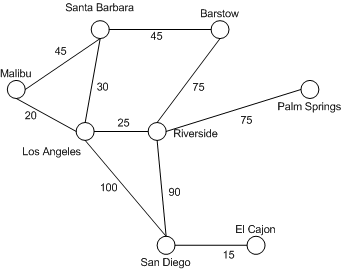

Fig 1: santa_barbara_map

*   Now create an Undirected Graph such as the romania_map, containing a dict of nodes as keys and neighbours as values.
*   Start exploring from Santa Barbara and try to find El Cajon in the map using.


*   Start exploring from Barstow and try to find El Cajon in the map.
*   Now show the visualisation of the map [Figure 1] from the task and see how different searching algorithms perform / how frontier expands in each of the following search algoriths:


> 1) Breadth First Tree Search

> 2) Depth First Tree Search

> 3) Breadth First Search

> 4) Depth First Graph Search

> 5) Uniform Cost Search

> 6) Depth Limited search

> 7) Iterative Deepening Search

*   Repeat task 3






In [30]:
santa_barbara_map = UndirectedGraph(dict(
    Barstow = dict(Riverside = 75, Santa_Barbara = 45),
    El_Cajon = dict(San_Diego = 15),
    Los_Angeles = dict(Malibu = 20,Riverside = 25, San_Diego = 100),
    Malibu = dict(Los_Angeles = 20, Santa_Barbara = 45),
    Palm_Springs = dict(Riverside = 75),
    Riverside = dict(Barstow = 75, Los_Angeles = 25, Palm_Springs = 75, San_Diego = 90),
    Santa_Barbara = dict(Barstow = 45, Malibu = 45,Los_Angeles = 30),
    San_Diego = dict(El_Cajon = 15, Los_Angeles = 100,Riverside = 90))) 

In [31]:
santa_barbara_map.locations = dict(
    Barstow=(240,530), El_Cajon=(270,300), Los_Angeles=(120,420),
    Malibu=(80,450), Palm_Springs=(280,450), Riverside=(200,420),
    Santa_Barbara=(131,530), San_Diego=(210,300))

In [32]:
santa_barbara_locations = santa_barbara_map.locations
print(santa_barbara_locations)

{'Barstow': (240, 530), 'El_Cajon': (270, 300), 'Los_Angeles': (120, 420), 'Malibu': (80, 450), 'Palm_Springs': (280, 450), 'Riverside': (200, 420), 'Santa_Barbara': (131, 530), 'San_Diego': (210, 300)}


In [33]:
# node colors, node positions and node label positions
node_colors = {node: 'white' for node in santa_barbara_map.locations.keys()}
node_positions = santa_barbara_map.locations
node_label_pos = { k:[v[0],v[1]-10]  for k,v in santa_barbara_map.locations.items() }
edge_weights = {(k, k2) : v2 for k, v in santa_barbara_map.graph_dict.items() for k2, v2 in v.items()}

santa_barbara_graph_data = {  'graph_dict' : santa_barbara_map.graph_dict,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                         'edge_weights': edge_weights
                     }

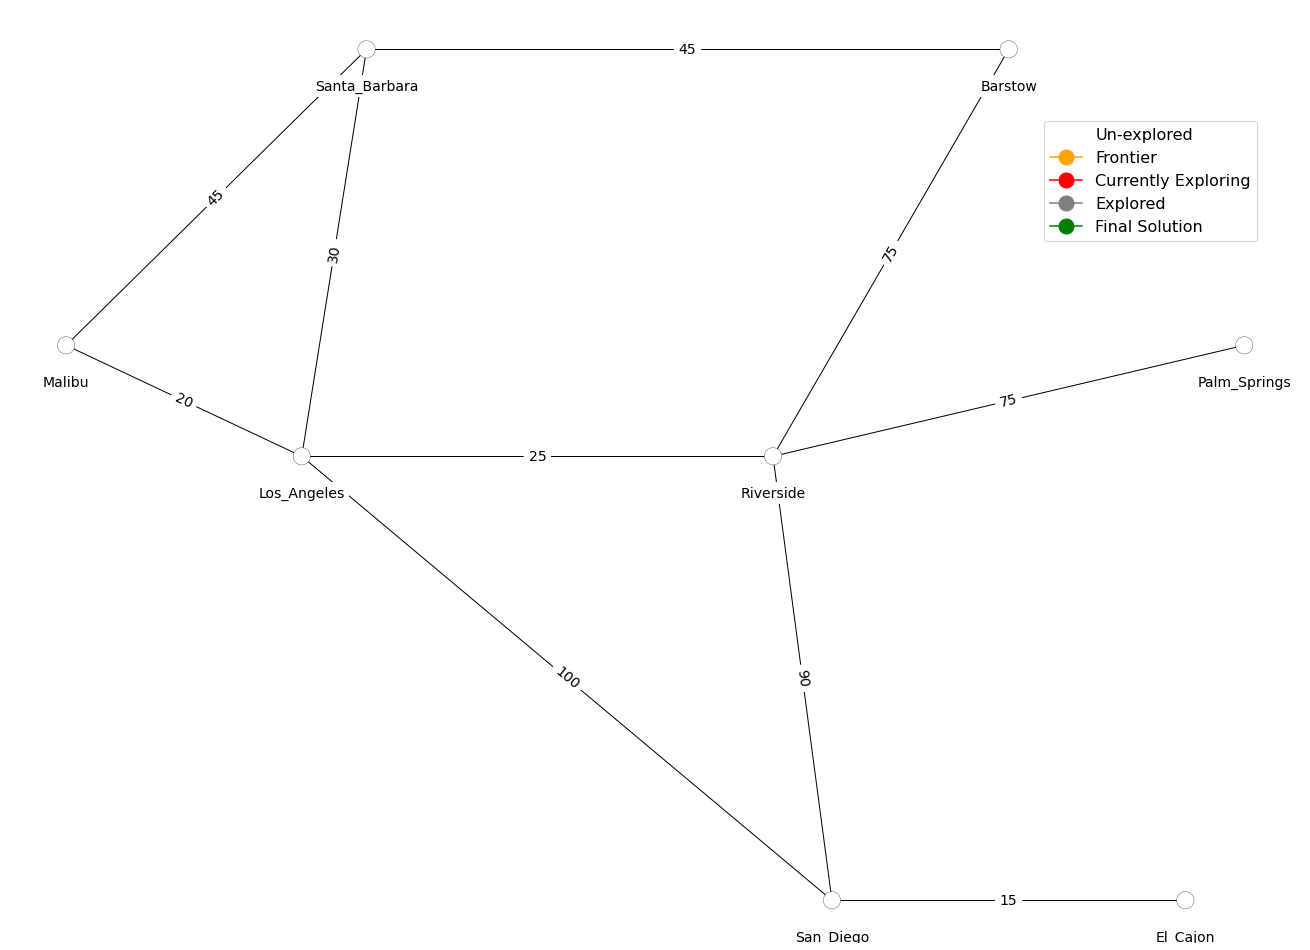

In [34]:
show_map(santa_barbara_graph_data)

## 1. Breadth First Tree Search 

## Santa_Barbara to  El_Cajon

In [35]:
all_node_colors = []
santa_barbara_problem = GraphProblem('Santa_Barbara', 'El_Cajon', santa_barbara_map)
display_visual(santa_barbara_graph_data, user_input=False, 
               algorithm=breadth_first_tree_search, 
               problem=santa_barbara_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## Barstow to  El_Cajon


In [36]:
all_node_colors = []
santa_barbara_problem = GraphProblem('Barstow', 'El_Cajon', santa_barbara_map)
display_visual(santa_barbara_graph_data, user_input=False, 
               algorithm=breadth_first_tree_search, 
               problem=santa_barbara_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 2.Depth First Tree Search 

## Santa_Barbara to  El_Cajon

In [37]:
all_node_colors = []
santa_barbara_problem = GraphProblem('Santa_Barbara', 'El_Cajon', santa_barbara_map)
display_visual(santa_barbara_graph_data, user_input=False, 
               algorithm=depth_first_tree_search, 
               problem=santa_barbara_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## Barstow to  El_Cajon


In [38]:
all_node_colors = []
santa_barbara_problem = GraphProblem('Barstow', 'El_Cajon', santa_barbara_map)
display_visual(santa_barbara_graph_data, user_input=False, 
               algorithm=depth_first_tree_search, 
               problem=santa_barbara_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 3.Breadth First Graph Search

### Santa_Barbara to El_Cajon

In [39]:
all_node_colors = []
santa_barbara_problem = GraphProblem('Santa_Barbara', 'El_Cajon', santa_barbara_map)
display_visual(santa_barbara_graph_data, user_input=False, 
               algorithm=breadth_first_search_graph, 
               problem=santa_barbara_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

### Barstow to El_Cajon

In [40]:
all_node_colors = []
santa_barbara_problem = GraphProblem('Barstow', 'El_Cajon', santa_barbara_map)
display_visual(santa_barbara_graph_data, user_input=False, 
               algorithm=breadth_first_search_graph, 
               problem=santa_barbara_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 4. Depth First Graph Search

### Santa_Barbara to El_Cajon

In [41]:
all_node_colors = []
santa_barbara_problem = GraphProblem('Santa_Barbara', 'El_Cajon', santa_barbara_map)
display_visual(santa_barbara_graph_data, user_input=False, 
               algorithm=depth_first_graph_search, 
               problem=santa_barbara_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

### Barstow to El_Cajon

In [42]:
all_node_colors = []
santa_barbara_problem = GraphProblem('Barstow', 'El_Cajon', santa_barbara_map)
display_visual(santa_barbara_graph_data, user_input=False, 
               algorithm=depth_first_graph_search, 
               problem=santa_barbara_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 5. UNIFORM COST SEARCH

### Santa_Barbara to El_Cajon

In [43]:
all_node_colors = []
santa_barbara_problem = GraphProblem('Santa_Barbara', 'El_Cajon', santa_barbara_map)
display_visual(santa_barbara_graph_data, user_input=False, 
               algorithm=uniform_cost_search_graph, 
               problem=santa_barbara_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

### Barstow to El_Cajon

In [44]:
all_node_colors = []
santa_barbara_problem = GraphProblem('Barstow', 'El_Cajon', santa_barbara_map)
display_visual(santa_barbara_graph_data, user_input=False, 
               algorithm=uniform_cost_search_graph, 
               problem=santa_barbara_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 6. DEPTH LIMITED SEARCH

### Santa_Barbara to El_Cajon

In [45]:
all_node_colors = []
santa_barbara_problem = GraphProblem('Santa_Barbara', 'El_Cajon', santa_barbara_map)
display_visual(santa_barbara_graph_data, user_input=False, 
               algorithm=depth_limited_search_for_vis, 
               problem=santa_barbara_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

### Barstow to El_Cajon

In [46]:
all_node_colors = []
santa_barbara_problem = GraphProblem('Barstow', 'El_Cajon', santa_barbara_map)
display_visual(santa_barbara_graph_data, user_input=False, 
               algorithm=depth_limited_search_for_vis, 
               problem=santa_barbara_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 7. ITERATIVE DEEPENING SEARCH

### Santa_Barbara to El_Cajon

In [47]:
all_node_colors = []
santa_barbara_problem = GraphProblem('Santa_Barbara', 'El_Cajon', santa_barbara_map)
display_visual(santa_barbara_graph_data, user_input=False, 
               algorithm=iterative_deepening_search_for_vis, 
               problem=santa_barbara_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

### Barstow to El_Cajon

In [48]:
all_node_colors = []
santa_barbara_problem = GraphProblem('Barstow', 'El_Cajon', santa_barbara_map)
display_visual(santa_barbara_graph_data, user_input=False, 
               algorithm=iterative_deepening_search_for_vis, 
               problem=santa_barbara_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

**Task 5** **[35%]**

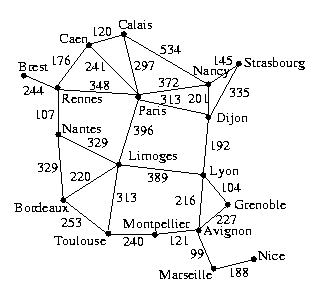

Fig 2: brest_map

*   Now create an Undirected Graph such as the romania_map, containing a dict of nodes as keys and neighbours as values.
*   Start exploring from Bordeaux and try to find Stasbourg  in the map using.
*   Start exploring from Brest and try to find Nice in the map.
*   Now show the visualisation of the map [Figure 1] from the task and see how different searching algorithms perform / how frontier expands in each of the following search algoriths:

> 1) Breadth First Tree Search

> 2) Depth First Tree Search

> 3) Breadth First Search

> 4) Depth First Graph Search

> 5) Uniform Cost Search

> 6) Depth Limited search

> 7) Iterative Deepening Search

*   Repeat task 3

In [49]:
brest_map = UndirectedGraph(dict(
    Avignon = dict(Grenoble = 227, Lyon = 104, Montpellier = 121),
    Bordeaux = dict(Limoges = 220,Nantes = 329,Toulouse = 253),
    Brest = dict(Rennes = 244),
    Caen = dict(Calais = 120,Paris = 241, Rennes = 176),
    Calais = dict(Caen = 120,Nancy = 534, Paris = 297),
    Dijon = dict(Nancy = 201, Paris = 313, Strasbourg = 335),
    Grenoble = dict (Avignon = 227, Lyon = 104),
    Limoges = dict(Bordeaux = 220,Lyon = 389,Nantes = 329,Paris = 396,Toulouse = 313),
    Lyon = dict(Dijon = 192,Grenoble = 104,Limoges = 389 ),
    Marseille = dict(Avignon = 99, Nice = 188),
    Montpellier = dict(Avignon = 121,Toulouse = 240),
    Nancy = dict(Calais = 534, Dijon = 201,Paris = 372, Strasbourg = 145),
    Nantes = dict(Bordeaux = 329, Limoges = 329,Rennes = 107),
    Nice = dict(Marseille = 188),
    Paris = dict(Caen = 241,Calais = 297,Dijon = 313,Limoges = 396, Nancy = 372,Rennes = 348),
    Rennes = dict(Brest = 244,Caen = 176,Nantes = 107, Paris = 348),
    Strasbourg = dict(Dijon = 335, Nancy = 145),
    Toulouse = dict(Bordeaux = 253,Limoges = 313,Montpellier = 240 )
))

brest_map.locations=dict(Calais=(240,530),Caen=(220,510),Nancy=(280,480),
                         Strasbourg=(300,500),Rennes=(200,480),Brest=(190,500),Paris=(250,470),Dijon=(280,450),
                         Lyon=(280,400),Nantes=(200,425),Limoges=(230,410),Bordeaux=(200,370),Grenoble=(300,370),
                         Avignon=(280,350),Montpellier=(250,350),Toulouse=(215,350),Marseille=(290,320),Nice=(320,330)
                        )

In [50]:
brest_locations = brest_map.locations
print(brest_locations)

{'Calais': (240, 530), 'Caen': (220, 510), 'Nancy': (280, 480), 'Strasbourg': (300, 500), 'Rennes': (200, 480), 'Brest': (190, 500), 'Paris': (250, 470), 'Dijon': (280, 450), 'Lyon': (280, 400), 'Nantes': (200, 425), 'Limoges': (230, 410), 'Bordeaux': (200, 370), 'Grenoble': (300, 370), 'Avignon': (280, 350), 'Montpellier': (250, 350), 'Toulouse': (215, 350), 'Marseille': (290, 320), 'Nice': (320, 330)}


In [51]:
# node colors, node positions and node label positions
node_colors = {node: 'white' for node in brest_map.locations.keys()}
node_positions = brest_map.locations
node_label_pos = { k:[v[0],v[1]-10]  for k,v in brest_map.locations.items() }
edge_weights = {(k, k2) : v2 for k, v in brest_map.graph_dict.items() for k2, v2 in v.items()}

brest_graph_data = {  'graph_dict' : brest_map.graph_dict,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                         'edge_weights': edge_weights
                     }

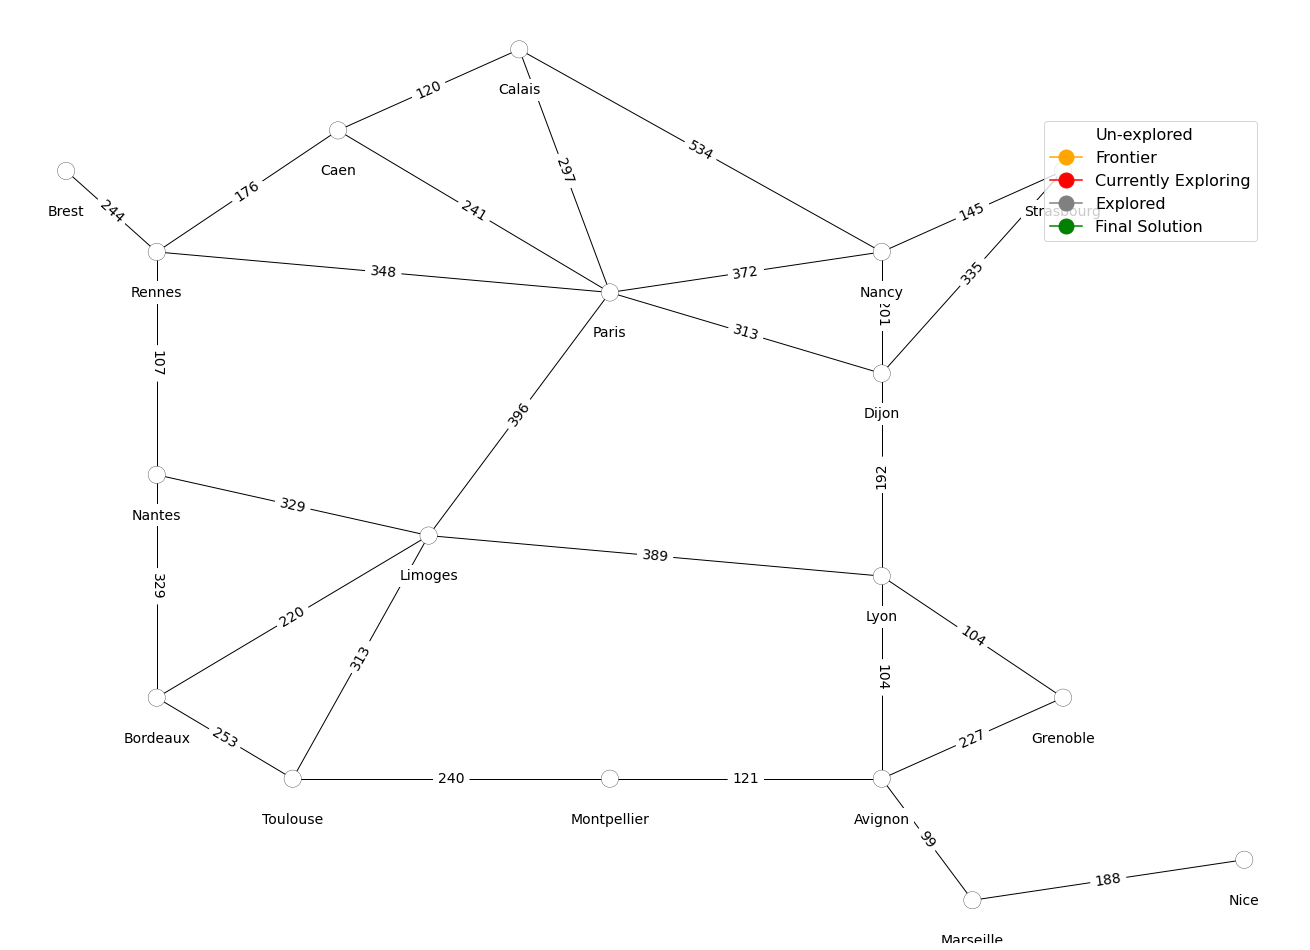

In [52]:
show_map(brest_graph_data)

## 1. Breadth First Tree Search 

### Bordeaux to Strasbourg

In [53]:
all_node_colors = []
brest_problem = GraphProblem('Bordeaux', 'Strasbourg', brest_map)
display_visual(brest_graph_data, user_input=False, 
               algorithm=breadth_first_tree_search, 
               problem=brest_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

### Brest to Nice

In [54]:
all_node_colors = []
brest_problem = GraphProblem('Brest', 'Nice', brest_map)
display_visual(brest_graph_data, user_input=False, 
               algorithm=breadth_first_tree_search, 
               problem=brest_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 2.Depth first tree search

### Bordeaux to Strasbourg

In [55]:
all_node_colors = []
brest_problem = GraphProblem('Bordeaux', 'Strasbourg', brest_map)
display_visual(brest_graph_data, user_input=False, 
               algorithm=depth_first_tree_search, 
               problem=brest_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

### Brest to Nice

In [56]:
all_node_colors = []
brest_problem = GraphProblem('Brest', 'Nice', brest_map)
display_visual(brest_graph_data, user_input=False, 
               algorithm=depth_first_tree_search, 
               problem=brest_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 3.Breadth First Graph Search

### Bordeaux to Strasbourg

In [57]:
all_node_colors = []
brest_problem = GraphProblem('Bordeaux', 'Strasbourg', brest_map)
display_visual(brest_graph_data, user_input=False, 
               algorithm=breadth_first_search_graph, 
               problem=brest_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

### Brest to Nice

In [58]:
all_node_colors = []
brest_problem = GraphProblem('Brest', 'Nice', brest_map)
display_visual(brest_graph_data, user_input=False, 
               algorithm=breadth_first_search_graph, 
               problem=brest_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 4. Depth First Graph Search

### Bordeaux to Strasbourg

In [59]:
all_node_colors = []
brest_problem = GraphProblem('Bordeaux', 'Strasbourg', brest_map)
display_visual(brest_graph_data, user_input=False, 
               algorithm=depth_first_graph_search, 
               problem=brest_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

### Brest to Nice

In [60]:
all_node_colors = []
brest_problem = GraphProblem('Brest', 'Nice', brest_map)
display_visual(brest_graph_data, user_input=False, 
               algorithm=depth_first_graph_search, 
               problem=brest_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 5. UNIFORM COST SEARCH

### Bordeaux to Strasbourg

In [61]:
all_node_colors = []
brest_problem = GraphProblem('Bordeaux', 'Strasbourg', brest_map)
display_visual(brest_graph_data, user_input=False, 
               algorithm=uniform_cost_search_graph, 
               problem=brest_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

### Brest to Nice

In [62]:
all_node_colors = []
brest_problem = GraphProblem('Brest', 'Nice', brest_map)
display_visual(brest_graph_data, user_input=False, 
               algorithm=uniform_cost_search_graph, 
               problem=brest_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 6. DEPTH LIMITED SEARCH

### Bordeaux to Strasbourg

In [63]:
all_node_colors = []
brest_problem = GraphProblem('Bordeaux', 'Strasbourg', brest_map)
display_visual(brest_graph_data, user_input=False, 
               algorithm=depth_limited_search_for_vis, 
               problem=brest_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

### Brest to Nice

In [64]:
all_node_colors = []
brest_problem = GraphProblem('Brest', 'Nice', brest_map)
display_visual(brest_graph_data, user_input=False, 
               algorithm=depth_limited_search_for_vis, 
               problem=brest_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

## 7. ITERATIVE DEEPENING SEARCH


### Bordeaux to Strasbourg

In [65]:
all_node_colors = []
brest_problem = GraphProblem('Bordeaux', 'Strasbourg', brest_map)
display_visual(brest_graph_data, user_input=False, 
               algorithm=iterative_deepening_search_for_vis, 
               problem=brest_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

### Brest to Nice

In [66]:
all_node_colors = []
brest_problem = GraphProblem('Brest', 'Nice', brest_map)
display_visual(brest_graph_data, user_input=False, 
               algorithm=iterative_deepening_search_for_vis, 
               problem=brest_problem)

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…